# Solving one electron problems with sturmian basis.
numpy (general operations), matplotlib (plotting), scipy (generalized eigenvalue problem), numba (faster calculations)

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numba import njit, prange
from tqdm import tqdm

# atoms definitions

ATOMS = {
    "Li": {
        "z": 3,
        "alpha_c": 0.1923,
        "rc": 0.61340824,
        "a1": 2.47718079,
        "a2": 1.84150932,
        "a3": -0.02169712,
        "a4": -0.11988362,
    },
    "Rb":
    {
        "z": 37,
        "alpha_c": 9.0760,
        "rc": 1.66242117,
        "a1": 3.69628474,
        "a2": 1.64915255,
        "a3": -9.86069196,
        "a4": 0.19579987,
    },
    "Cs":
    {
        "z": 55,
        "alpha_c": 15.6440,
        "rc": 1.92046930,
        "a1": 3.49546309,
        "a2": 1.47533800,
        "a3": -9.72143084,
        "a4": 0.02629242,
    },
}

### Generalized Laguerre polynomials
$L_0^{(\alpha)}(x) = 1$

$L_1^{(\alpha)}(x) = 1 + \alpha - x$

$L_n^{(\alpha)}(x) = \frac{(2n - 1 + \alpha - x) L_{n-1}^{(\alpha)}(x) - (n - 1 + \alpha) L_{n-2}^{(\alpha)}(x)}{n}$

### Sturmian Basis

### Hydrogen potential

### Rydberg potential

In [118]:

def GLP(x, N, alpha):  # Generalized Laguerre polynomials
    L0 = np.ones_like(x)
    L1 = 1.0 + alpha - x

    if N == 0:
        Ln = L0
    if N == 1:
        Ln = L1

    for n in range(2, N + 1):
        Ln = (((2 * n - 1 + alpha - x)) * L1 - (n - 1 + alpha) * L0) / n
        L0, L1 = L1, Ln
    
    print(Ln)
    
    return Ln



def Skl(r, k, l, q):  # Sturmian
    # np.sqrt((factorial(k) / (2 * factorial(2 * l + 1 + k)))) before usage of log gamma function
    return (
        np.sqrt(1 / 2)
        * np.exp(
            (1 / 2) * (np.math.lgamma(k + 1) - np.math.lgamma(2 * l + 2 + k))
        )  # Using log gamma to avoid overflow
        * np.exp(-q * r)
        * ((2 * q * r) ** (l + 1))
        * GLP(2 * q * r, k, 2 * l + 1)
    )



def V1(r):
    return -1 / r



def Z(r, z, a1, a2, a3, a4):
    return 1 + (z - 1) * np.exp(-a1 * r) - r * (a3 + a4 * r) * np.exp(-a2 * r)



def V2(r, alpha_c, rc, a1, a2, a3, a4, z):
    return -(Z(r, z, a1, a2, a3, a4)) / r - (alpha_c / (2 * r**4)) * (1 - (np.exp(-((r / rc) ** 6))))

### HB


In [90]:
def HB(N, l, q, r_min, r_max, Nr, dtype):
    print(f"H,B calculation for N={N}, Nr={Nr}")

    x = np.linspace(np.sqrt(r_min), np.sqrt(r_max), Nr + 1, dtype=dtype)
    B = np.zeros((N, N), dtype=dtype)
    H = np.zeros((N, N), dtype=dtype)
    S = np.zeros((N, Nr), dtype=dtype)
    S_diff = np.zeros((N, Nr), dtype=dtype) # derivative of S

    r1 = x**2
    r = r1[0:-1]
    dr = r1[1:] - r

    V_r = V1(r)

    return HBC(N=N, l=l, q=q, r=r, r1=r1, S=S, S_diff=S_diff, dr=dr, V_r=V_r, H=H, B=B)

# @njit(parallel=True, fastmath=True)
def HBC(N, l, q, r, r1, S, S_diff, dr, V_r, H, B):

    for n in tqdm(range(N)):
        Sn = Skl(r1, n, l, q)
        S[n] = Sn[0:-1]
        S_diff[n] = (Sn[1:]-Sn[:-1])/dr
        
    for n in tqdm(range(N)):
        for k in range(n, N):
            
            B[n, k] = (S[n] * S[k] * dr).sum()
            
            # Hamiltonian
            H[n, k] = (
                (
                    (1/2)*S_diff[n]*S_diff[k] + 
                    S[n]*S[k]*(V_r + (l)*(l+1)/(2*r**2))
                )
                * (dr)
            ).sum()
            
            # H is symmetric
            if n != k:
                B[k, n] = B[n, k] 
                H[k, n] = H[n, k]
            
    return H, B

/tmp/ipykernel_4397/2018219747.py:25: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (1 / 2) * (np.math.lgamma(k + 1) - np.math.lgamma(2 * l + 2 + k))


[ 2.00100000e+0003 -2.92618558e+0000  5.16573618e+0000 ...
  6.96100901e+1808  9.66686355e+1808  1.34233025e+1809]


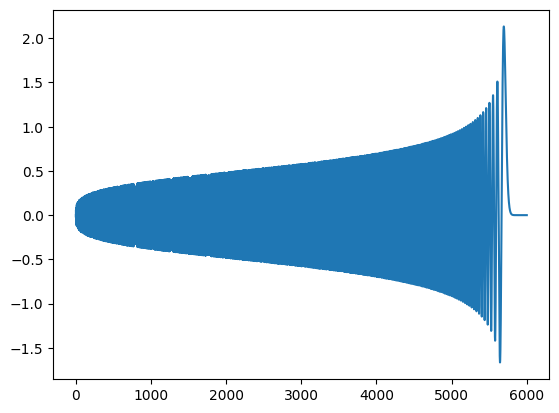

In [122]:
x = np.linspace(0, 6000, 10000, dtype=np.longdouble)
y = Skl(x, 2000, 0, 0.7)
plt.plot(x, y)

In [93]:
N = 500
l = 0
q = 0.7

r_min = 10**-13
r_max = 1600
Nr = 10**4

# V = lambda r: V2(r, **ATOMS["Li"])
V = lambda r: V1(r)

H, B = HB(N, l, q, r_min, r_max, Nr, np.longdouble)

eigenvalues, eigenvectors = sp.linalg.eigh(H, B)

H,B calculation for N=500, Nr=10000


  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_4397/2176941034.py:23: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (1 / 2) * (np.math.lgamma(k + 1) - np.math.lgamma(2 * l + 2 + k))
100%|██████████| 500/500 [00:57<00:00,  8.63it/s]


In [104]:
l = 0
q = 0.7

r_min = 10**-13
r_max = 6000
Nr = 10**4

N_list = np.linspace(300, 2000, 2).astype(int)
energies = np.zeros((N_list.max(),N_list.shape[0]))
energies.fill(np.nan)

for i, N in enumerate(N_list):
    H, B = HB(N, l, q, r_min, r_max, Nr, np.longdouble)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies[:eigenvalues.shape[0], i] = eigenvalues
    except Exception as e:
        pass

energies = np.array(energies)

for i in range(20, 30):
    En = (-1/2 *(1/(i + 1)**2))
    plt.plot(N_list, np.log10(np.abs(energies[i] - En)/np.abs(En)), label=f"n={i+1}")

# plt.ylim(0.0, 0.6)
plt.title(f"Convergence of energy with respect to Hamiltonian size (Number of grid points = {Nr:.3g})")
plt.xlabel("Hamiltonian size (N)")
plt.ylabel("log10(Energy Relative error)")
plt.legend()

H,B calculation for N=300, Nr=10000


  0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_4397/2176941034.py:23: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (1 / 2) * (np.math.lgamma(k + 1) - np.math.lgamma(2 * l + 2 + k))
100%|██████████| 300/300 [00:20<00:00, 14.45it/s]


H,B calculation for N=2000, Nr=10000


  4%|▍         | 81/2000 [01:11<28:16,  1.13it/s]


KeyboardInterrupt: 

In [95]:
energies

array([[-5.01573461e-01],
       [-1.25274848e-01],
       [-5.56506336e-02],
       [-3.12942150e-02],
       [-2.00242754e-02],
       [-1.39037148e-02],
       [-1.02138339e-02],
       [-7.81927569e-03],
       [-6.17774910e-03],
       [-5.00367787e-03],
       [-4.13506206e-03],
       [-3.47445016e-03],
       [-2.96036681e-03],
       [-2.55247688e-03],
       [-2.22342596e-03],
       [-1.95413200e-03],
       [-1.73095526e-03],
       [-1.54393667e-03],
       [-1.38566719e-03],
       [-1.25054268e-03],
       [-1.13426081e-03],
       [-1.03347437e-03],
       [-9.45546551e-04],
       [-8.68320587e-04],
       [-7.99095143e-04],
       [-7.31283799e-04],
       [-6.56373165e-04],
       [-5.71335131e-04],
       [-4.76661879e-04],
       [-3.73181477e-04],
       [-2.61500486e-04],
       [-1.42047024e-04],
       [-1.51339577e-05],
       [ 1.19001573e-04],
       [ 2.60174697e-04],
       [ 4.08237962e-04],
       [ 5.63071936e-04],
       [ 7.24578524e-04],
       [ 8.9

H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30


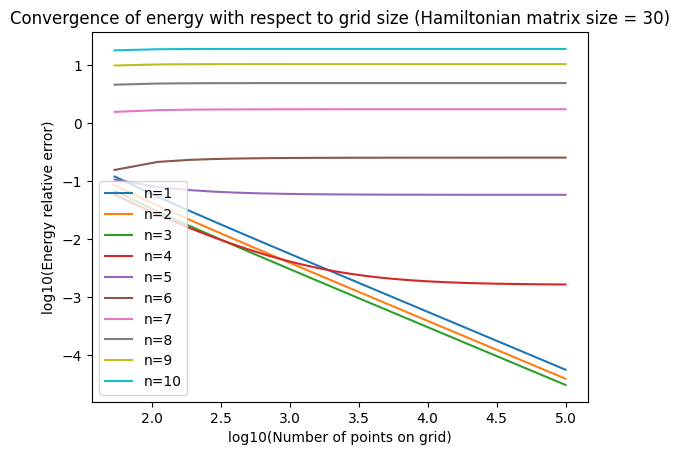

In [15]:
N = 30
l = 0
q = 0.7

r_min = 10**-13
r_max = 50

energies = []
Nr_list = np.linspace(np.sqrt(1.0), np.sqrt(100000), 100)
Nr_list = np.round(Nr_list**2).astype(int)

# Nr_list = [100, 120, 140, 160, 180, 200, 300, 400, 600, 1000, 2000, 5000, 9000, 10000, 11000, 30000, 100000, 500000, 1000000,]
for Nr in Nr_list:
    H, B = HB(N, l, q, r_min, r_max, Nr, np.float64)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies.append(np.array(eigenvalues))
    except Exception as e:
        energies.append(np.array([np.nan]*N))
energies = np.array(energies)

energies = energies.T

for i in range(10):
    En = (-1/2 *(1/(i + 1)**2))
    plt.plot(np.log10(Nr_list), np.log10(np.abs(energies[i] - En)/np.abs(En)), label=f"n={i+1}")

plt.title(f"Convergence of energy with respect to grid size (Hamiltonian matrix size = {N})")
plt.xlabel("log10(Number of points on grid)")
plt.ylabel("log10(Energy relative error)")
plt.legend()